In [77]:
from collections import namedtuple
from collections import defaultdict
from collections import Counter
import os
import subprocess

class ObjectCnt:
    def __init__(self, **kwargs) -> None:
        self.__dict__.update(kwargs)

    def __repr__(self):
        return "ObjectCnt(thread=%d, cls=%s, ptr='%s', cnt=%d, %s, size=%d, typ='%s')" % (
            self.thread,
            self.cls,
            self.ptr,
            self.cnt,
            '' if self.length is None else ('length=%d' % self.length),
            self.size,
            self.typ
        )


def add_snapshot(snapshots, snap, last_n):
    snapshots.append(snap)
    if last_n and len(snapshots) > last_n:
        snapshots = snapshots[1:]
    return snapshots

def find_file(logfile):
    if os.path.exists(logfile):
        return logfile
    
    cmd = "find /tmp/ -maxdepth 1 -type f -size +1b -name 'file*' -exec ls -lth {} +".split(' ')
    files = subprocess.check_output(cmd)
    print(files)

def read_logs(logfile, last_n = None):
    snapshots = []
    cur_dict = set()

    with open(logfile, 'r') as file:
        for line in file:
            line = line.strip()
            if not line: continue

            if 'Dump Snapshot' in line:
                if not cur_dict: continue
                
                snapshots = add_snapshot(snapshots, cur_dict, last_n)
                cur_dict = set()
            elif 'Skipping Snapshot' not in line:
                # My log: th=172166293241342555, class=[B, ptr=0x60d1df368, cnt=64
                assert 'My log' in line, ('unexpected line format for ' + line)
                parts = line.split(', ')

                th_str = parts[0]
                if th_str.startswith('My log array:'): typ = 'array'
                elif th_str.startswith('My log obj:'): typ = 'object'
                else: assert False, ('unexpected log format for ' + th_str)

                tup = ObjectCnt(
                    thread = int(th_str[th_str.find('th=') + len('th='):]),
                    cls = parts[1][len('class='):],
                    ptr = parts[2][len('ptr='):],
                    cnt = int(parts[3][len('cnt='):]),
                    length = (None if typ == 'object' else int(parts[-2][len('len='):])),
                    size = int(parts[-1][len('size='):]),
                    typ = typ)
                
                cur_dict.add(tup)


    snapshots = add_snapshot(snapshots, cur_dict, last_n)


    # print(snapshots)
    print('Got %d snapshots' % len(snapshots))
    for idx, snap in enumerate(snapshots):
        print('Snapshot #%d with size=%d' % (idx, len(snap)))

    return snapshots

In [73]:
find_file('whatever')

b''


In [78]:
logfile = "/tmp/fileRWEFPy"
snapshots = read_logs(logfile, 20)

Got 20 snapshots
Snapshot #0 with size=263653
Snapshot #1 with size=263762
Snapshot #2 with size=264393
Snapshot #3 with size=263501
Snapshot #4 with size=264746
Snapshot #5 with size=263709
Snapshot #6 with size=263123
Snapshot #7 with size=200764
Snapshot #8 with size=256672
Snapshot #9 with size=255959
Snapshot #10 with size=257701
Snapshot #11 with size=261081
Snapshot #12 with size=262663
Snapshot #13 with size=263805
Snapshot #14 with size=264144
Snapshot #15 with size=263601
Snapshot #16 with size=264547
Snapshot #17 with size=264310
Snapshot #18 with size=263797
Snapshot #19 with size=263882


In [96]:
snap = snapshots[-2]

In [80]:
def is_system_class(cls):
    return any(cls.startswith(prefix) for prefix in ('sun/', 'java/', 'jdk/', 'openj9/', 'com/', 'javax/'))

def is_primitive_class(cls):
    return any(cls.startswith(prefix) for prefix in ('array', 'byte', 'char', 'int', 'long', 'double', 'boolean', 'float', 'short', '[I', '[B', '[L'))

def is_user_class(cls):
    return not (is_system_class(cls) or is_primitive_class(cls))

In [81]:
[log for log in snap if is_user_class(log.cls)]

[ObjectCnt(thread=12932931462944640147, cls=io/netty/channel/ChannelOption, ptr='0x60d97a5b8', cnt=414, , size=32, typ='object'),
 ObjectCnt(thread=13142808626110693759, cls=io/netty/util/AsciiString, ptr='0x60ef30338', cnt=7863, , size=32, typ='object'),
 ObjectCnt(thread=10302040510792888049, cls=io/netty/util/internal/PriorityQueueNode, ptr='0x60d85a570', cnt=0, length=0, size=32, typ='array'),
 ObjectCnt(thread=10762289100850382315, cls=io/netty/util/collection/IntObjectHashMap, ptr='0x60ee94be8', cnt=371687, , size=48, typ='object'),
 ObjectCnt(thread=10762289100850382315, cls=io/netty/handler/codec/http2/DefaultHttp2Connection$PropertyKeyRegistry, ptr='0x60ee94cb8', cnt=8666, , size=24, typ='object'),
 ObjectCnt(thread=10762289100850382315, cls=io/netty/handler/codec/http2/DefaultHttp2Connection$ConnectionStream, ptr='0x60ee94ce8', cnt=34621, , size=40, typ='object'),
 ObjectCnt(thread=10762289100850382315, cls=io/netty/handler/codec/http2/DefaultHttp2Connection$DefaultEndpoint, 

In [82]:
cls_dict = Counter([(x.cls, x.typ) for x in snap if is_user_class(x.cls)])
print(cls_dict)

Counter({('io/netty/util/AsciiString', 'object'): 6667, ('io/netty/buffer/PoolSubpage', 'object'): 4608, ('io/netty/util/internal/shaded/org/jctools/queues/MpscArrayQueue', 'object'): 3840, ('io/netty/buffer/PoolThreadCache$SubPageMemoryRegionCache', 'object'): 3744, ('io/netty/handler/codec/http2/HpackHeaderField', 'object'): 3205, ('io/netty/handler/codec/http2/HpackEncoder$HeaderEntry', 'object'): 3192, ('scala/collection/immutable/$colon$colon', 'object'): 1690, ('scala/collection/immutable/ArraySeq$ofRef', 'object'): 1324, ('io/netty/buffer/LongPriorityQueue', 'object'): 1152, ('scala/Some', 'object'): 1105, ('io/netty/handler/codec/CodecOutputList', 'object'): 768, ('io/netty/channel/DefaultChannelHandlerContext', 'object'): 726, ('io/netty/buffer/PoolChunkList', 'object'): 576, ('io/netty/buffer/PoolThreadCache$MemoryRegionCache$Entry', 'object'): 566, ('io/netty/util/HashedWheelTimer$HashedWheelBucket', 'object'): 512, ('io/netty/util/internal/DefaultPriorityQueue', 'object'): 

In [83]:
print(Counter([log.cls for log in snap if log.typ == 'array']))

Counter({'byte': 46239, 'java/lang/Object': 10446, 'short': 6530, 'long': 2398, 'java/lang/Class': 1790, 'int': 1753, 'java/util/HashMap$Node': 1125, 'java/lang/String': 808, 'char': 671, 'java/lang/ref/SoftReference': 490, 'java/util/concurrent/ConcurrentHashMap$Node': 447, 'java/util/WeakHashMap$Entry': 394, 'java/lang/invoke/LambdaForm$Name': 257, 'com/fasterxml/jackson/databind/JavaType': 225, 'io/netty/buffer/PoolThreadCache$MemoryRegionCache': 192, 'sun/reflect/generics/tree/TypeArgument': 179, 'io/netty/buffer/PoolSubpage': 144, 'java/lang/ThreadLocal$ThreadLocalMap$Entry': 144, 'io/netty/util/internal/PriorityQueueNode': 130, '[C': 104, '[S': 96, 'java/security/ProtectionDomain': 91, 'java/lang/ClassValue$Entry': 88, 'java/lang/invoke/MethodHandle': 85, 'sun/reflect/generics/tree/FieldTypeSignature': 72, 'io/netty/util/concurrent/GenericFutureListener': 64, 'java/lang/reflect/Type': 63, 'io/netty/handler/codec/DefaultHeaders$HeaderEntry': 53, 'java/security/Principal': 50, 'io/

In [84]:
[log for log in snap if 'MainClass' in log.cls or 'InnerClass' in log.cls]

[]

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

def display_stats_by_class(percent=None, counter=None):
    if counter is None:
        counter = Counter(item.cls for item in snap)

    if percent is None:
        labels = list(counter.keys())
        counts = list(counter.values())
    elif percent > 0:
        assert 0 < percent < 1, "Invalid percent value, expected in [0, 1]"
        most_common = counter.most_common(int(len(counter) * percent))

        labels = [item[0] for item in most_common]
        counts = [item[1] for item in most_common]
    else:
        assert -1 < percent < 0, "Invalid percent value, expected in [-1, 0]"

        distribution = counter.most_common()[::-1]
        least_common = distribution[:int(len(distribution) * -percent)]

        labels = [item[0] for item in least_common]
        counts = [item[1] for item in least_common]

    plt.figure(figsize=(25, 8))

    # Create a bar chart
    plt.bar(labels, counts)

    plt.xlabel("Class type")
    plt.ylabel("Count")
    plt.title("Distribution of Items by Class")

    plt.yscale('log')
    plt.xticks(rotation=90)

    plt.show()

In [18]:
counter = Counter(item.cls for item in snap)

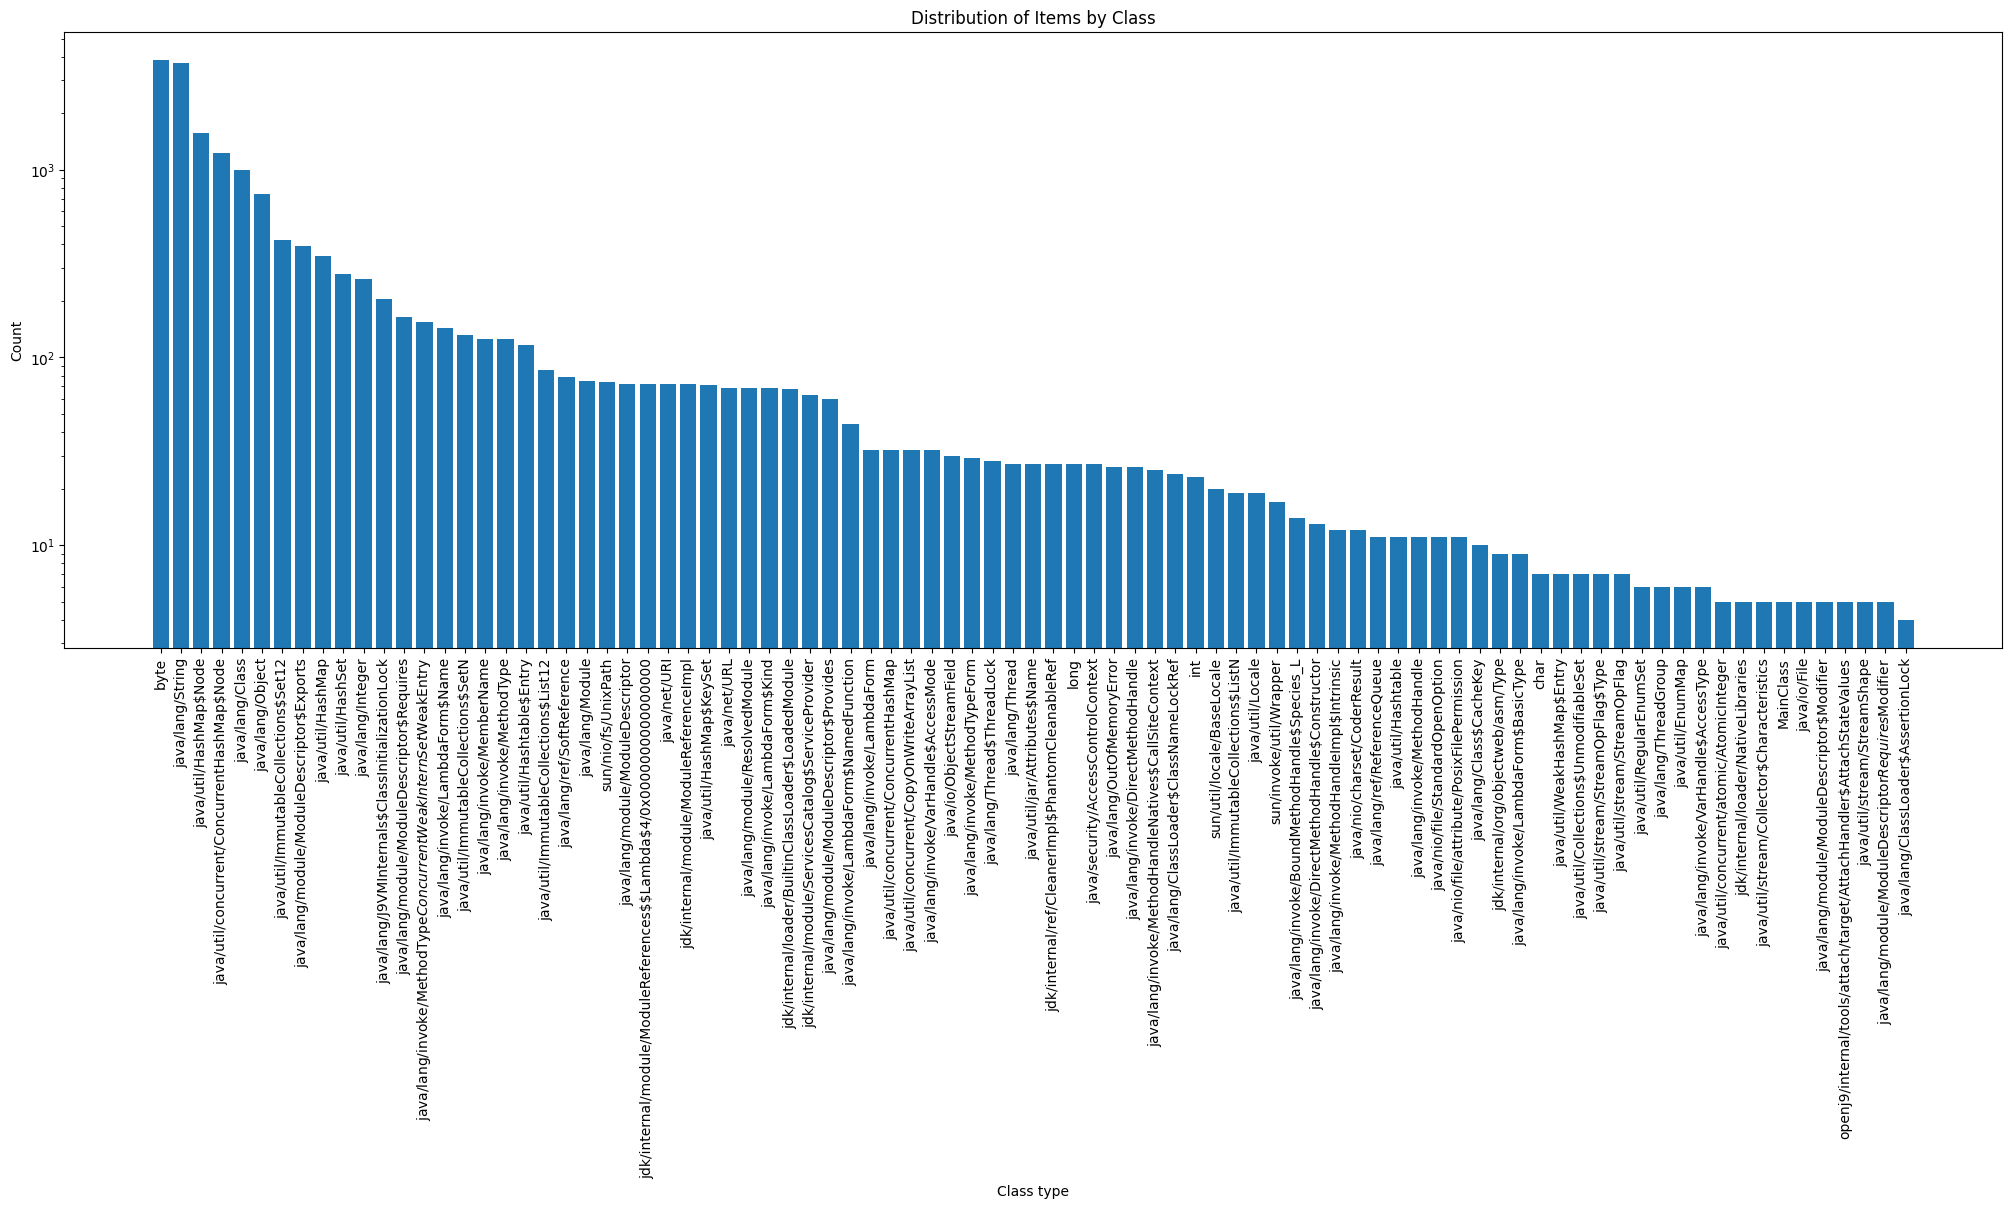

In [19]:
display_stats_by_class(0.3, counter)

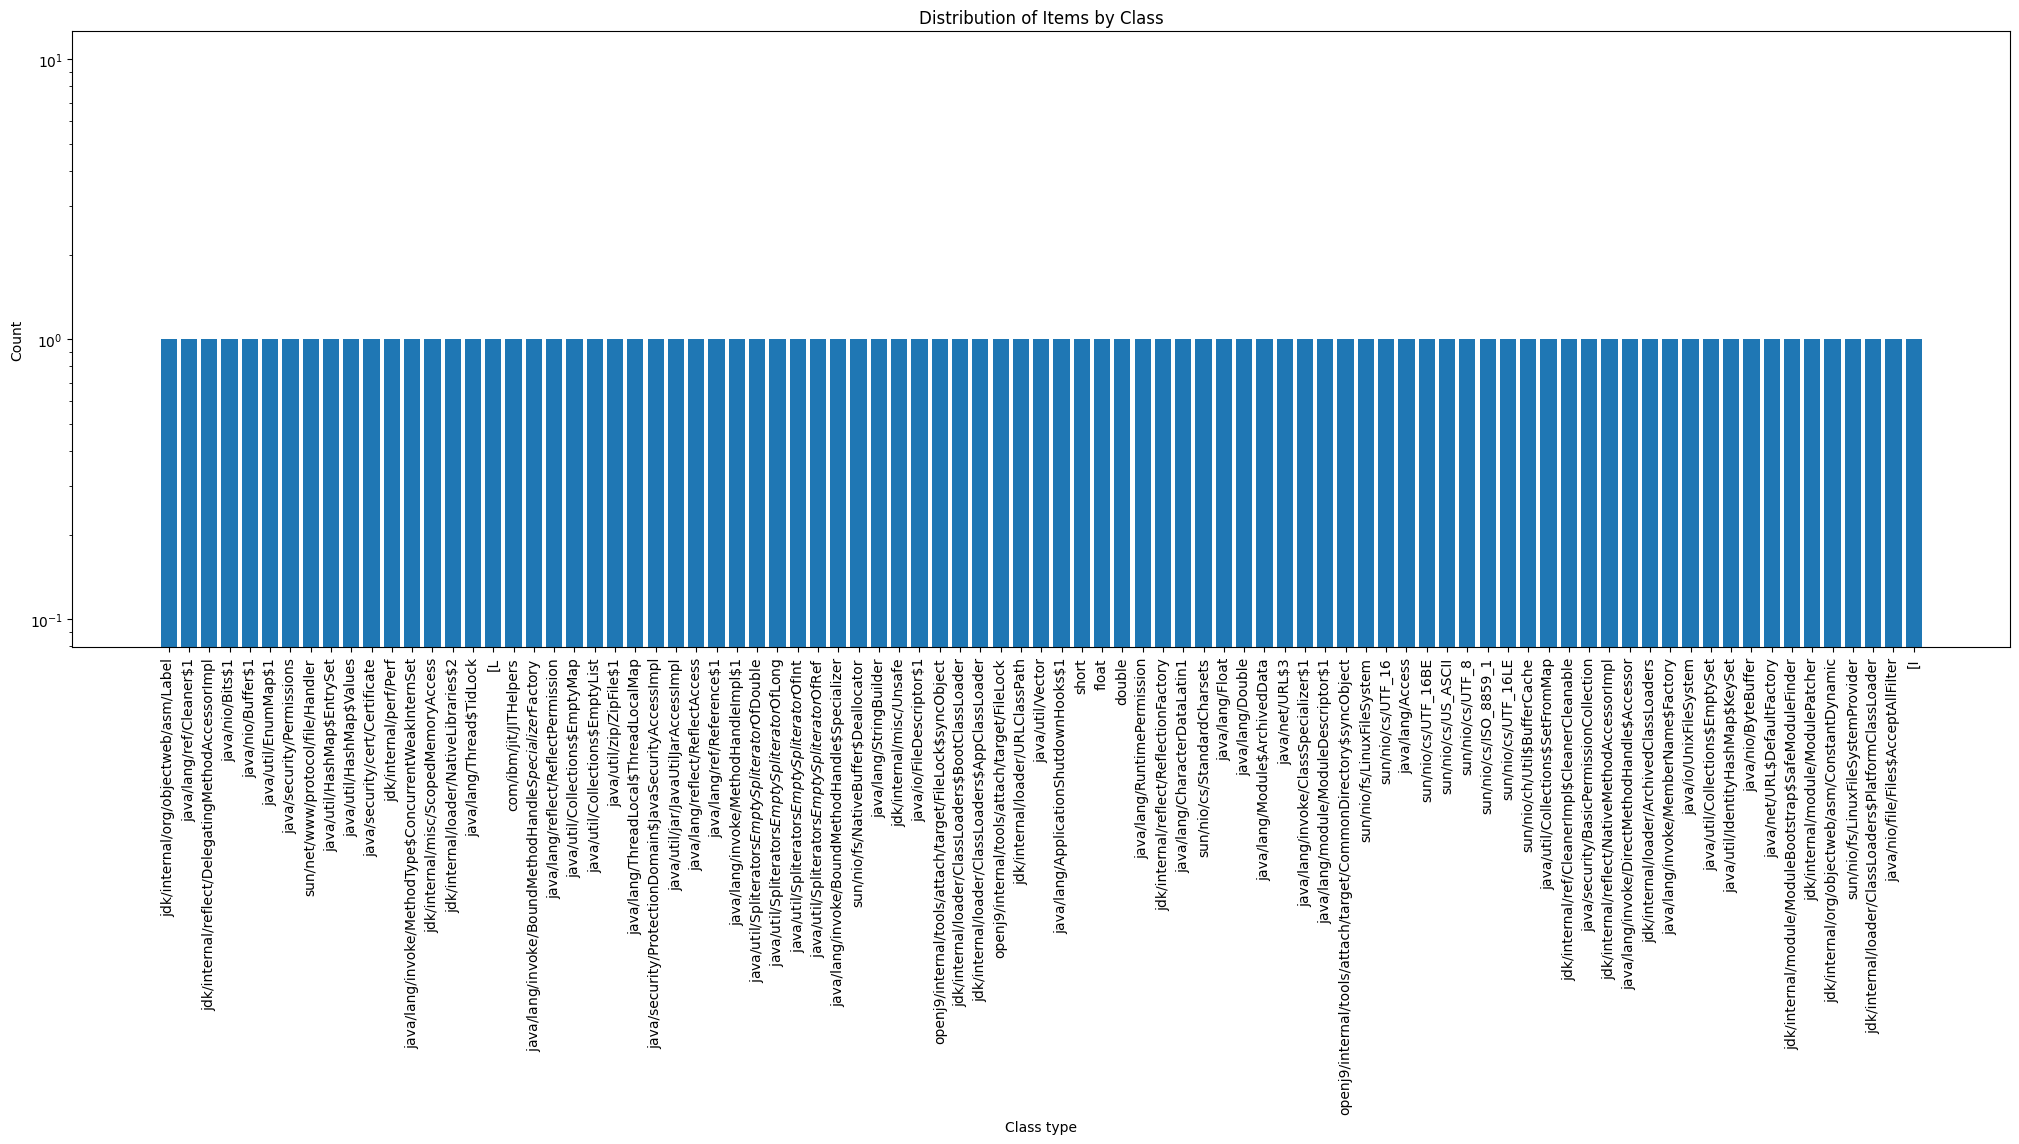

In [20]:
display_stats_by_class(-0.3, counter)

Distribution of Elements by counter [4, 0, 58, 0, 414, 80, 7, 56, 2, 68, 40, 7, 22, 0, 0, 32, 19, 17, 3, 28, 126, 36, 85, 55, 21, 180, 0, 2, 40, 28, 4, 31, 8, 2, 16, 2, 2, 0, 0, 2, 22, 3, 2, 0, 4, 0, 2, 2, 2, 16, 0, 2, 4, 2, 21, 58, 4, 2, 8, 2, 3, 0, 0, 32, 14, 2, 3, 2, 8, 0, 1, 2, 3, 6, 62, 0, 57, 2, 4, 3, 0, 1, 15, 2, 21, 3, 8, 0, 264, 2, 4, 564, 20, 2, 48, 2, 22, 7, 1260, 387, 3, 3, 22, 3, 38, 2, 26, 2, 22, 2, 0, 11, 12, 3, 21, 0, 36, 250, 8, 2, 3, 0, 0, 290, 4, 2, 4, 0, 0, 14, 1, 2, 26, 1, 0, 192, 52, 2, 4, 445, 21, 0, 3, 3, 21, 2, 0, 0, 40, 2, 24, 0, 0, 2, 30, 8, 22, 0, 118, 9, 25, 2, 7, 0, 0, 27, 51, 2, 4, 0, 0, 0, 1, 2, 5, 0, 0, 0, 1, 2, 23, 0, 4, 0, 16, 2, 2, 0, 0, 40, 26, 20, 14, 0, 4, 0, 11, 8, 26, 0, 2, 0, 19, 7, 21, 7, 0, 2, 35, 2, 23, 2, 0, 0, 43, 0, 2, 0, 2, 153, 25, 0, 272, 0, 8, 13, 43, 2, 30, 33, 13, 13, 66, 0, 21, 0, 0, 13, 51, 16, 712, 0, 3, 8, 29, 2, 20, 0, 0, 17, 152, 7, 4, 0, 0, 66, 84, 0, 4, 0, 0, 0, 8, 0, 21, 0, 0, 0, 4, 0, 316, 0, 215, 0, 1, 0, 20, 12, 144, 0, 

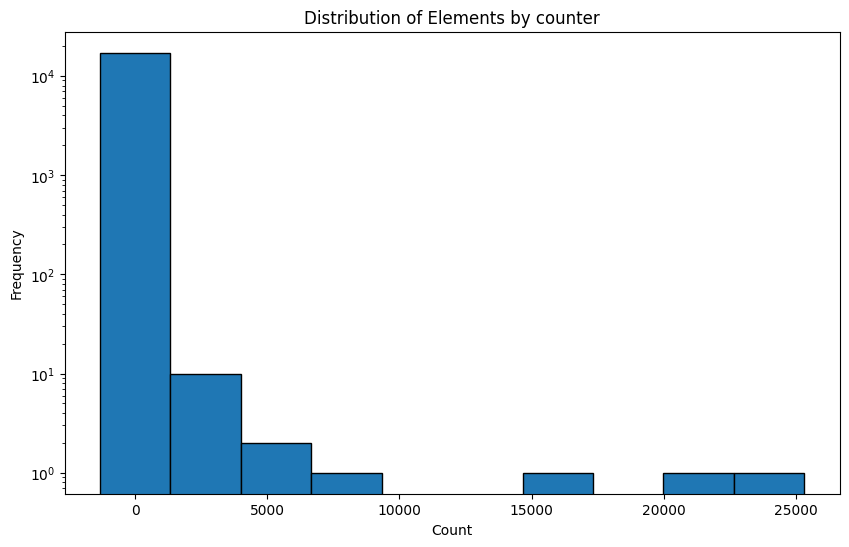

In [36]:
import numpy as np

counts = [item.cnt for item in snap]
hist, bins = np.histogram(counts)

# Set the width of the figure
fig = plt.figure(figsize=(10, 6))  # Adjust the width as desired

# Create a bar chart
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='black')

# Set labels and title
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.title("Distribution of Elements by counter")

plt.yscale('log')

# Show the chart
plt.show()

In [24]:
snap

{ObjectCnt(thread=10210784372030632746, cls=java/util/HashMap$Node, ptr='0x60d53e480', cnt=4, , size=32, typ='object'),
 ObjectCnt(thread=12505827649773569451, cls=java/lang/String, ptr='0x60d57d140', cnt=0, , size=24, typ='object'),
 ObjectCnt(thread=8955923091730844609, cls=byte, ptr='0x60d5930d8', cnt=58, length=58, size=82, typ='array'),
 ObjectCnt(thread=8955923091730844609, cls=java/lang/J9VMInternals$ClassInitializationLock, ptr='0x60d15a238', cnt=0, , size=16, typ='object'),
 ObjectCnt(thread=8955923091730844609, cls=byte, ptr='0x60d31d288', cnt=414, length=136, size=160, typ='array'),
 ObjectCnt(thread=5774529462745775609, cls=java/util/HashMap$Node, ptr='0x60d52cf70', cnt=80, , size=32, typ='object'),
 ObjectCnt(thread=10210784372030632746, cls=java/util/HashMap$Node, ptr='0x60d5378f0', cnt=7, , size=32, typ='object'),
 ObjectCnt(thread=12505827649773569451, cls=openj9/internal/tools/attach/target/AttachHandler, ptr='0x60d54e4c0', cnt=56, , size=144, typ='object'),
 ObjectCnt

In [25]:
snap_list = list(snap)

In [27]:
snap_list_sorted = sorted(snap_list, reverse=True, key=lambda item: item.cnt)
snap_list_sorted

[ObjectCnt(thread=12505827649773569451, cls=java/util/ImmutableCollections$SetN, ptr='0x60d412b00', cnt=26646, , size=24, typ='object'),
 ObjectCnt(thread=12505827649773569451, cls=byte, ptr='0x60d1de308', cnt=22360, length=4, size=28, typ='array'),
 ObjectCnt(thread=12505827649773569451, cls=java/lang/Object, ptr='0x60d412b18', cnt=17881, length=252, size=1032, typ='array'),
 ObjectCnt(thread=5774529462745775609, cls=java/util/ImmutableCollections$SetN, ptr='0x60d130600', cnt=8143, , size=24, typ='object'),
 ObjectCnt(thread=12505827649773569451, cls=byte, ptr='0x60d175208', cnt=6032, length=76, size=100, typ='array'),
 ObjectCnt(thread=12505827649773569451, cls=java/lang/String, ptr='0x60d1de2f0', cnt=5590, , size=24, typ='object'),
 ObjectCnt(thread=8955923091730844609, cls=byte, ptr='0x60d16aba0', cnt=5032, length=34, size=58, typ='array'),
 ObjectCnt(thread=10210784372030632746, cls=byte, ptr='0x60d180e38', cnt=4698, length=74, size=98, typ='array'),
 ObjectCnt(thread=895592309173

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def display_freq_bins(objects, group_by_sizes=True):
    # Extract the access counts and sizes from the object counts
    access_counts = np.array([obj.cnt for obj in objects])
    object_sizes = np.array([obj.size for obj in objects])

    # Step 1: Create bins to group the access counts automatically
    num_bins = 10  # Adjust the number of bins as needed
    bin_edges = np.histogram_bin_edges(access_counts, bins=num_bins)

    # Step 2: Calculate the total size and object count for each bin
    total_sizes = np.zeros(num_bins - 1, dtype=int)
    total_object_counts = np.zeros(num_bins - 1, dtype=int)

    for i in range(num_bins - 1):
        mask = (access_counts >= bin_edges[i]) & (access_counts < bin_edges[i + 1])
        total_sizes[i] = np.sum(object_sizes[mask])
        total_object_counts[i] = np.sum(mask)

    if group_by_sizes: y_axis = total_sizes
    else: y_axis = total_object_counts
    # print(y_axis)

    # Step 3: Display the histogram
    plt.figure(figsize=(23, 6))  # Adjust figure size as needed
    plt.bar(range(num_bins - 1), y_axis, width=0.8, align='center')
    plt.xlabel("Bins of Access Counts")
    if group_by_sizes: plt.ylabel("Size of Objects")
    else: plt.ylabel("Number of Objects")
    plt.title("Histogram of Objects by Access Counts")
    plt.xticks(range(num_bins - 1), [f"{int(bin_edges[i])}-{int(bin_edges[i + 1])}" for i in range(num_bins - 1)])
    plt.grid(axis='y')
    plt.yscale('log')

    plt.show()

    # Display the total size for each bin
    if group_by_sizes:
        print("Total Number of Objects for Each Bin:")
        for i in range(num_bins - 1):
            print(f"Bin {int(bin_edges[i])}-{int(bin_edges[i + 1])}: {total_object_counts[i]} objects")
    else:
        print("Total Size for Each Bin:")
        for i in range(num_bins - 1):
            print(f"Bin {int(bin_edges[i])}-{int(bin_edges[i + 1])}: {total_sizes[i]} bytes")



[251695    702    541   1441   2085    100    116   6790    101]


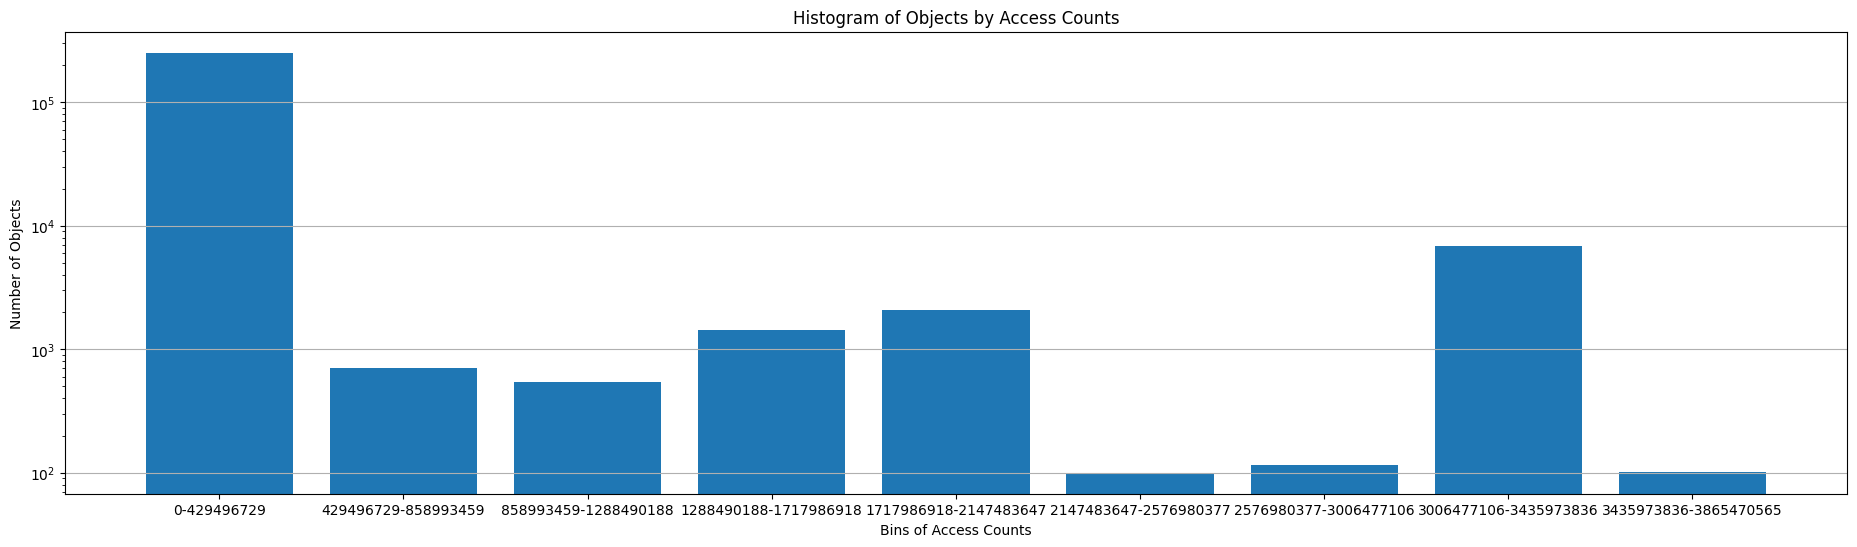

Total Size for Each Bin:
Bin 0-429496729: 31127070 bytes
Bin 429496729-858993459: 67952 bytes
Bin 858993459-1288490188: 57682 bytes
Bin 1288490188-1717986918: 191173 bytes
Bin 1717986918-2147483647: 260993 bytes
Bin 2147483647-2576980377: 9130 bytes
Bin 2576980377-3006477106: 22320 bytes
Bin 3006477106-3435973836: 566201 bytes
Bin 3435973836-3865470565: 10651 bytes


In [97]:
display_freq_bins(snap, group_by_sizes=False)

[31127070    67952    57682   191173   260993     9130    22320   566201
    10651]


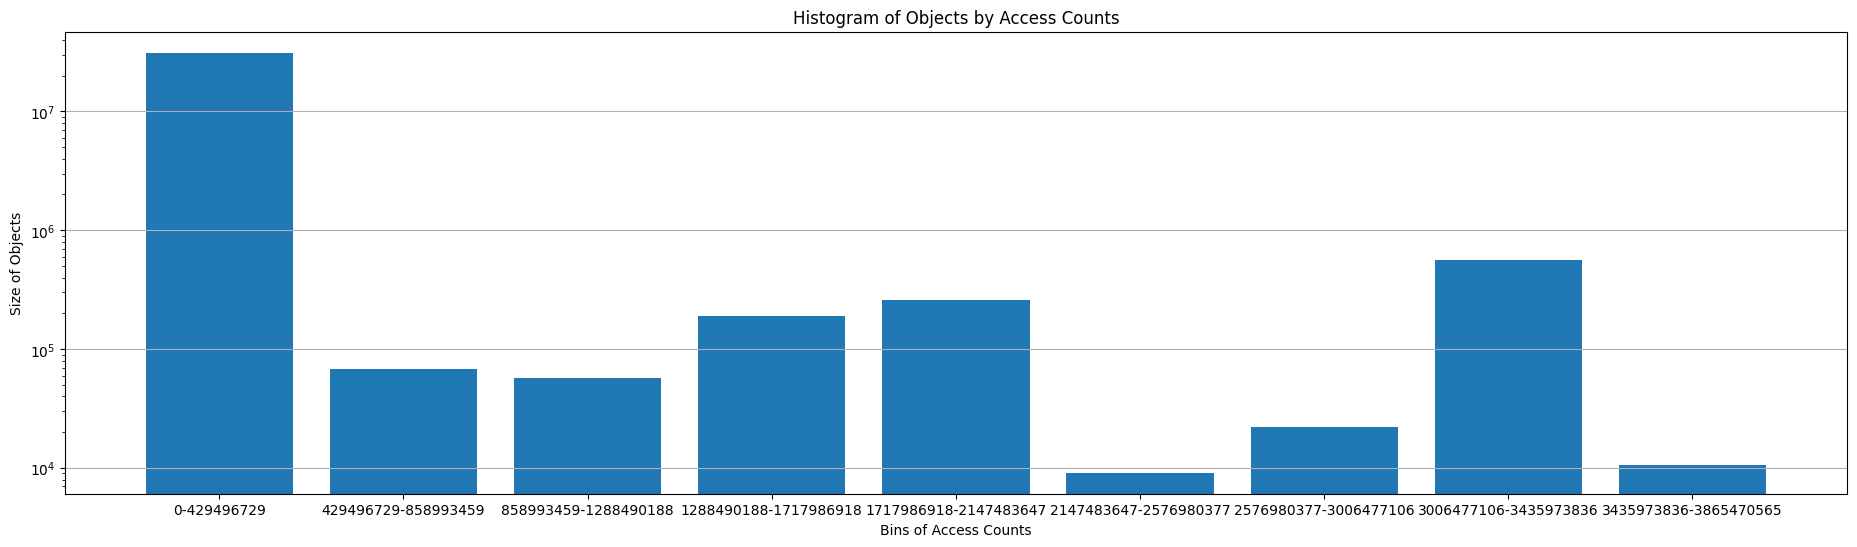

Total Number of Objects for Each Bin:
Bin 0-429496729: 251695 objects
Bin 429496729-858993459: 702 objects
Bin 858993459-1288490188: 541 objects
Bin 1288490188-1717986918: 1441 objects
Bin 1717986918-2147483647: 2085 objects
Bin 2147483647-2576980377: 100 objects
Bin 2576980377-3006477106: 116 objects
Bin 3006477106-3435973836: 6790 objects
Bin 3435973836-3865470565: 101 objects


In [98]:
display_freq_bins(snap)

In [102]:
last_snapshots = snapshots[-4:-1]
print(len(last_snapshots))

3


[31150616    67837    58306   191399   261233     9471    22648   566078
    10688]


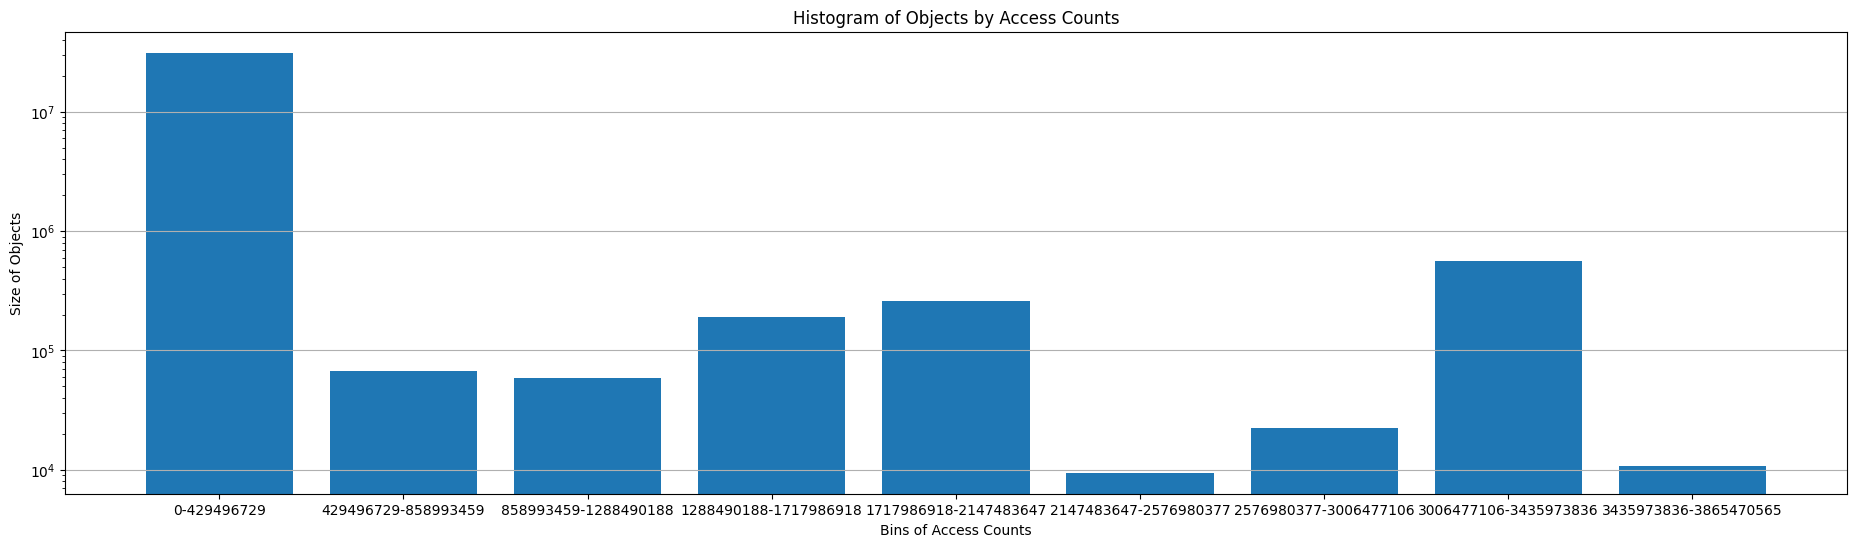

Total Number of Objects for Each Bin:
Bin 0-429496729: 252366 objects
Bin 429496729-858993459: 699 objects
Bin 858993459-1288490188: 556 objects
Bin 1288490188-1717986918: 1444 objects
Bin 1717986918-2147483647: 2092 objects
Bin 2147483647-2576980377: 108 objects
Bin 2576980377-3006477106: 122 objects
Bin 3006477106-3435973836: 6823 objects
Bin 3435973836-3865470565: 102 objects
[31146190    67736    57967   191215   261548     9222    22609   565169
    10665]


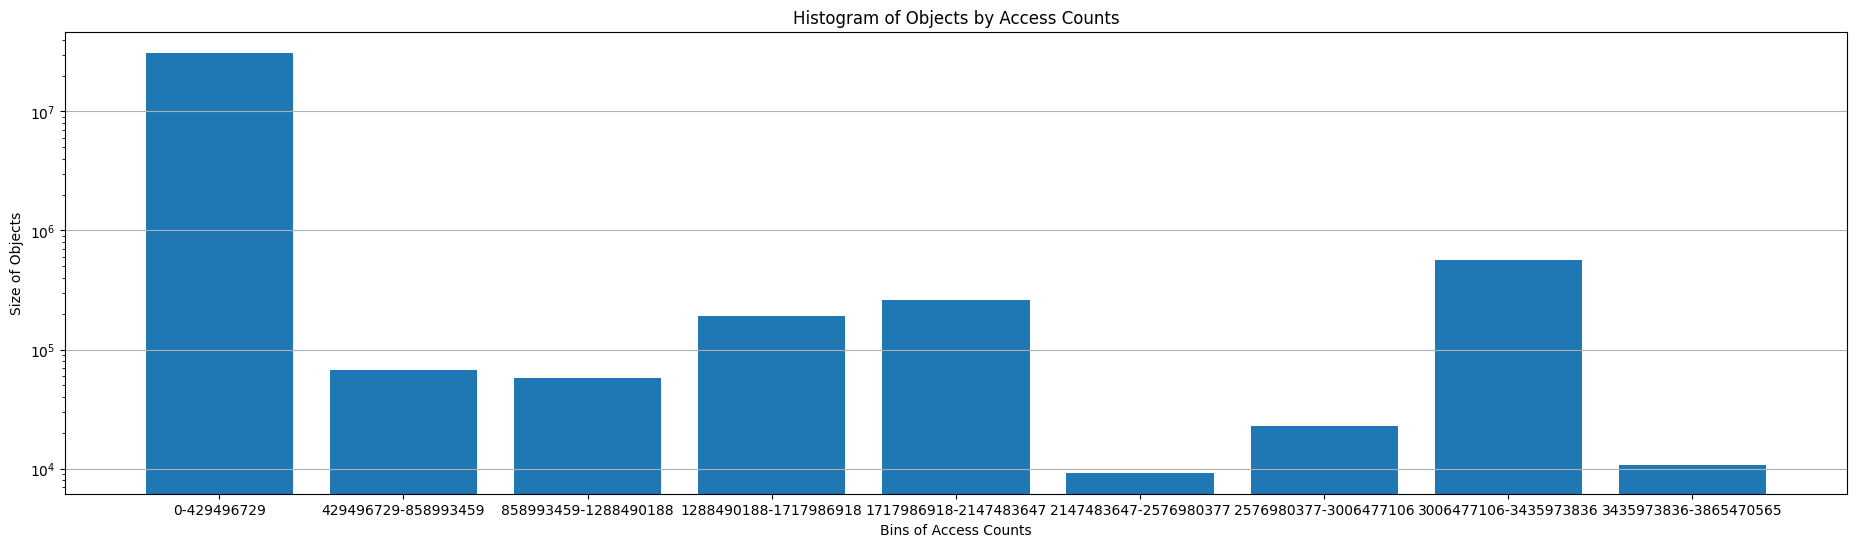

Total Number of Objects for Each Bin:
Bin 0-429496729: 252176 objects
Bin 429496729-858993459: 699 objects
Bin 858993459-1288490188: 546 objects
Bin 1288490188-1717986918: 1438 objects
Bin 1717986918-2147483647: 2096 objects
Bin 2147483647-2576980377: 101 objects
Bin 2576980377-3006477106: 121 objects
Bin 3006477106-3435973836: 6796 objects
Bin 3435973836-3865470565: 101 objects
[31127070    67952    57682   191173   260993     9130    22320   566201
    10651]


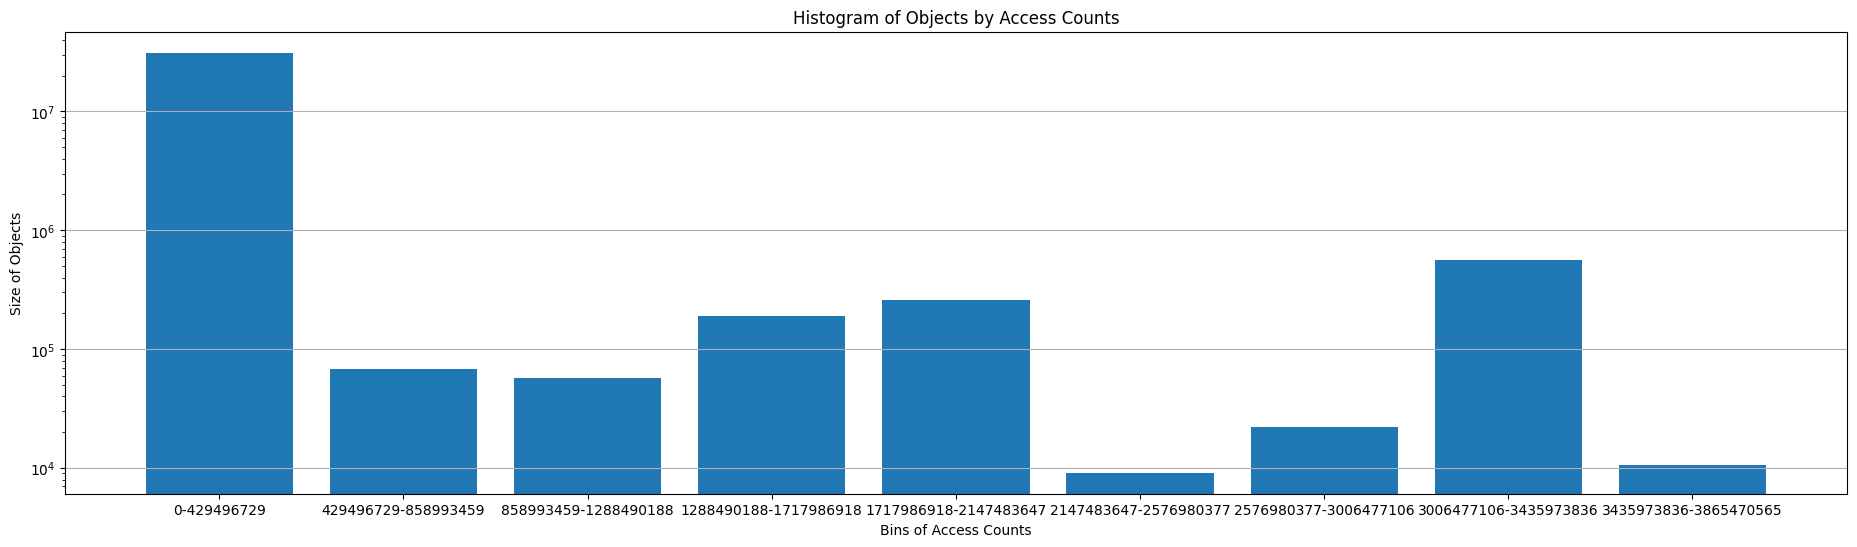

Total Number of Objects for Each Bin:
Bin 0-429496729: 251695 objects
Bin 429496729-858993459: 702 objects
Bin 858993459-1288490188: 541 objects
Bin 1288490188-1717986918: 1441 objects
Bin 1717986918-2147483647: 2085 objects
Bin 2147483647-2576980377: 100 objects
Bin 2576980377-3006477106: 116 objects
Bin 3006477106-3435973836: 6790 objects
Bin 3435973836-3865470565: 101 objects


In [103]:
for _snap in last_snapshots:
    display_freq_bins(_snap)